# Mispecification

In [1]:
import sys
import utils_1 as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
reload(utils)

C:\Users\muham\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<module 'utils_1' from 'D:\\(Akademik)\\(CDT in Mathematics of Random Systems)\\[Broker, Informed, Noise Traders, Filtering Game]\\utils_1.py'>

In [2]:
%load_ext autoreload
%autoreload 2
np.random.seed(100)

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')

In [4]:
variable_colors = ['tab:olive', 'tab:green', 'tab:red', 'tab:blue']

In [5]:
font1 = 16 #25
font2 = 20

## 1. Choose the signal filtering strategy & benchmark

In [6]:
# choosing strategy type
# available strategies are "our model", "alternative filter", "naive filter"
# mispecify parameter represents whether the broker mispecifies the informed trader's inventory or not

strategy_type = "our model"
mispecify = False
file_name = f'{strategy_type}'
if mispecify:
    file_name += f' (mispecified inventory)'
    
alpha_est_name = {"our model": r'$\hat{\alpha}_t$',
                  "alternative filter": r'$\hat{\alpha}^{alt}_t$',
                  "naive filter": r'$\hat{\alpha}^{naive}_t$'}

## 2. Set the parameters & functions involved

In [7]:
kappa_alpha_base = 5.
sigma_alpha_base = 1.
theta_B_base = 10.
sigma_B_base = 60.

params_env = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': kappa_alpha_base, 'sigma_alpha': sigma_alpha_base, 
              'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

env = utils.environment(**params_env)

params_uninf = {'kappa' : 15., 'nu0' : 0., 'sigma' : 100., 'k' : 2e-03}

uninf_trader = utils.uninformed(**params_uninf)

scale_ivp = 1 # change this to change the scale in solving ivp for V_B

nsims = 10_000

W = env.simulate_BM_with_drift(x0=0, mu=0, sigma=1, nsims=nsims)

seed_alpha = 20240820
np.random.seed(seed_alpha)
alpha = env.simulate_alpha(nsims = nsims)
nu_U = uninf_trader.simulate_uninformed_flow(env, nsims=nsims)

In [8]:
np.random.seed(seed_alpha)
alpha_1 = env.simulate_alpha(nsims = nsims)

In [9]:
err = 0.5

param_list_name = ['kappa_alpha', 'sigma_alpha', 'theta_B', 'sigma_B']
err_name = [f'+{err*100:1.0f}\%', f'-{err*100:1.0f}\%']
ratio_list = np.array([1 + err, 1 - err])

kappa_alpha_list = dict(zip(err_name, kappa_alpha_base*ratio_list))
sigma_alpha_list = dict(zip(err_name, sigma_alpha_base*ratio_list))
theta_B_list = dict(zip(err_name, theta_B_base*ratio_list))
sigma_B_list = dict(zip(err_name, sigma_B_base*ratio_list))

param_list_base = dict(zip(param_list_name, [kappa_alpha_base,
                                            sigma_alpha_base,
                                            theta_B_base,
                                            sigma_B_base]))

param_list_val = dict(zip(param_list_name, [kappa_alpha_list,
                                            sigma_alpha_list,
                                            theta_B_list,
                                            sigma_B_list]))

In [10]:
param_list_val

{'kappa_alpha': {'+50\\%': 7.5, '-50\\%': 2.5},
 'sigma_alpha': {'+50\\%': 1.5, '-50\\%': 0.5},
 'theta_B': {'+50\\%': 15.0, '-50\\%': 5.0},
 'sigma_B': {'+50\\%': 90.0, '-50\\%': 30.0}}

In [11]:
param_list_base

{'kappa_alpha': 5.0, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

In [12]:
err_name

['+50\\%', '-50\\%']

In [13]:
for err_name, param_val in param_list_val['kappa_alpha'].items():
    print(err_name, param_val)

+50\% 7.5
-50\% 2.5


## 4. Simulate the informed trader & broker's strategies

In [14]:
import simulations_1 as simulations

## 4a. Mispecification from broker's POV

In [13]:
sim_collections = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_collections = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_misp_collections = dict(zip(param_list_name, [[] for param in param_list_name]))
broker_collections = dict(zip(param_list_name, [[] for param in param_list_name]))

In [15]:
for param_name in param_list_name:
    
    for err_name, param_val in param_list_val[param_name].items():
        
        param = param_list_base.copy()
        param[param_name] = param_val

        params_env_misp = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': param['kappa_alpha'], 'sigma_alpha': param['sigma_alpha'], 
                           'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

        env_misp = utils.environment(**params_env_misp)

        scale_ivp = 1 # change this to change the scale in solving ivp for V_B

        params_inf = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                          'sigma_B' : sigma_B_base, 'mu_B' : 0., 'theta_B' : theta_B_base, 'sigma_0' : 0, 'c_importance' : 1}

        params_inf_misp = {'env': env_misp, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                          'sigma_B' : param['sigma_B'], 'mu_B' : 0., 'theta_B' : param['theta_B'], 'sigma_0' : 0, 'c_importance' : 1}

        inf_trader =  utils.informed(**params_inf)

        inf_trader_misp =  utils.informed(**params_inf_misp)

        inf_trader_collections[param_name].append(inf_trader)

        inf_trader_misp_collections[param_name].append(inf_trader_misp)

        params_broker = {'env': env_misp, 'inf': inf_trader_misp, 'uninf': uninf_trader,
                         'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                         'sigma_B': inf_trader_misp.sigma_B, 'mu_B': inf_trader_misp.mu_B, 'theta_B': inf_trader_misp.theta_B, 
                         'sigma_0': 0, 'scale_ivp': scale_ivp}

        broker = utils.broker(**params_broker)

        broker_collections[param_name].append(broker)

        model = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                       W, alpha, nu_U, 
                                       strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

        sim_collections[param_name].append(model)

        benchmarks = dict.fromkeys([f'benchmark {i+1}' for i in range(3)])
        outperform = dict.fromkeys([f'benchmark {i+1}' for i in range(3)])

        print(f"{param_name} ({err_name})")
        print(f'{param}\n')

        for i, bench in enumerate(benchmarks.keys()):
            benchmarks[bench] = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                                       W, alpha, nu_U, 
                                                       strategy = bench, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)
            outperform[bench] = 1e06*((model.Portfolio_B - benchmarks[bench].Portfolio_B)/benchmarks[bench].total_value_traded).reshape((-1,))

            t_stat, p_value = stats.ttest_1samp(outperform[bench], 0, alternative='greater')
            print(f'Outperformance: {outperform[bench].mean():.1f} ({outperform[bench].std():.1f})')
            print(f"T-test for outperformance w.r.t benchmark {i+1}")
            print("T statistic:", t_stat)
            print("P-value:", p_value, "\n")
            
        print('-----------------------------------------------')

kappa_alpha (+50%)
{'kappa_alpha': 7.5, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -11.4 (572.0)
T-test for outperformance w.r.t benchmark 1
T statistic: -1.994469780107925
P-value: 0.9769360785744204 

Outperformance: 37.7 (358.0)
T-test for outperformance w.r.t benchmark 2
T statistic: 10.535704931800703
P-value: 4.036781135963498e-26 

Outperformance: 87.6 (694.9)
T-test for outperformance w.r.t benchmark 3
T statistic: 12.60237126862133
P-value: 1.9272050799480758e-36 

-----------------------------------------------
kappa_alpha (-50%)
{'kappa_alpha': 2.5, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -12.2 (569.1)
T-test for outperformance w.r.t benchmark 1
T statistic: -2.1350089767699134
P-value: 0.9836077428977641 

Outperformance: 36.9 (364.4)
T-test for outperformance w.r.t benchmark 2
T statistic: 10.137864927144294
P-value: 2.4511675271369786e-24 

Outperformance: 87.0 (692.6)
T-test for outperformance w.r.t benchmark 3
T

## Mispecification from informed trader's POV

In [14]:
sim_collections_1 = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_collections_1 = dict(zip(param_list_name, [[] for param in param_list_name]))

In [15]:
param_list_val['kappa_alpha'].items()

dict_items([('+50%', 7.5), ('-50%', 2.5)])

In [16]:
param_list_name

['kappa_alpha', 'sigma_alpha', 'theta_B', 'sigma_B']

In [17]:
for param_name in param_list_name:
    
    params_inf_br = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                  'sigma_B' : sigma_B_base, 'mu_B' : 0., 'theta_B' : theta_B_base, 'sigma_0' : 0, 'c_importance' : 1}
    
    inf_trader_br =  utils.informed(**params_inf_br)
    
    params_broker = {'env': env, 'inf': inf_trader_br, 'uninf': uninf_trader,
                     'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                     'sigma_B': inf_trader_br.sigma_B, 'mu_B': inf_trader_br.mu_B, 'theta_B': inf_trader_br.theta_B, 
                     'sigma_0': 0, 'scale_ivp': scale_ivp}

    broker = utils.broker(**params_broker)
    
    benchmark = simulations.simulation(env, inf_trader_br, uninf_trader, broker, 
                                       W, alpha, nu_U, 
                                       strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)
    
    for err_name, param_val in param_list_val[param_name].items():
        
        param = param_list_base.copy()
        param[param_name] = param_val

        params_env_misp = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': param['kappa_alpha'], 'sigma_alpha': param['sigma_alpha'], 
                           'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

        env_misp = utils.environment(**params_env_misp)

        scale_ivp = 1 # change this to change the scale in solving ivp for V_B
        
        params_inf = {'env': env_misp, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                      'sigma_B' : param['sigma_B'], 'mu_B' : 0., 'theta_B' : param['theta_B'], 'sigma_0' : 0, 'c_importance' : 1}

        inf_trader =  utils.informed(**params_inf)

        inf_trader_collections_1[param_name].append(inf_trader)

        model = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                       W, alpha, nu_U, 
                                       strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

        sim_collections_1[param_name].append(model)

        outperform = 1e06*((model.Portfolio_I - benchmark.Portfolio_I)/benchmark.total_value_traded).reshape((-1,))

        t_stat, p_value = stats.ttest_1samp(outperform, 0, alternative='greater')
        print(f"{param_name} ({err_name})")
        print(f'{param}\n')
        print(f'Outperformance: {outperform.mean():.1f} ({outperform.std():.1f})')
        print(f"T-test for outperformance")
        print("T statistic:", t_stat)
        print("P-value:", p_value, "\n")
            
        print('-----------------------------------------------')

kappa_alpha (+50%)
{'kappa_alpha': 7.5, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -0.9 (177.0)
T-test for outperformance
T statistic: -0.5107436363277836
P-value: 0.695229071632451 

-----------------------------------------------
kappa_alpha (-50%)
{'kappa_alpha': 2.5, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -21.4 (343.6)
T-test for outperformance
T statistic: -6.215283377757733
P-value: 0.9999999997336194 

-----------------------------------------------
sigma_alpha (+50%)
{'kappa_alpha': 5.0, 'sigma_alpha': 1.5, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: 0.0 (0.0)
T-test for outperformance
T statistic: 1.0882357842687518
P-value: 0.13825863001498429 

-----------------------------------------------
sigma_alpha (-50%)
{'kappa_alpha': 5.0, 'sigma_alpha': 0.5, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -0.0 (0.0)
T-test for outperformance
T statistic: -1.0779798092327373
P-value: 0.8594656142511294 

----------

In [19]:
param_list_base

{'kappa_alpha': 2.5, 'sigma_alpha': 0.5, 'theta_B': 5.0, 'sigma_B': 30.0}

## Externalisation & Stressing

In [15]:
import utils as utils_old
import simulations as simulations_old

In [16]:
scale_ivp = 100000 # change this to change the scale in solving ivp for V_B

params_inf = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
              'sigma_B' : 60., 'mu_B' : 0., 'theta_B' : 10., 'sigma_0' : 0}

inf_trader =  utils_old.informed(**params_inf)

params_broker = {'env': env, 'inf': inf_trader, 'uninf': uninf_trader,
                 'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                 'sigma_B': inf_trader.sigma_B, 'mu_B': inf_trader.mu_B, 'theta_B': inf_trader.theta_B, 
                 'sigma_0': 0, 'scale_ivp': scale_ivp}

broker = utils_old.broker(**params_broker)

D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:213: RuntimeWarning: divide by zero encountered in divide
  GF0 = -(env.b/env.sigma_s)**2 * V_I - f3/2 - (env.b/(2*inf.k*f2))
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:227: RuntimeWarning: invalid value encountered in divide
  GF6 = -(dGF3 * (GF3 + env.corr*GF4) + dGF3 * (env.corr * GF3 + GF4))/(GF5**2)
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:230: RuntimeWarning: invalid value encountered in divide
  GF7 = GF_alpha/GF5
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:233: RuntimeWarning: invalid value encountered in divide
  kF = (GF3 + env.corr * GF4)/GF5


# Our model: filter I

In [17]:
strategy = "our model"

In [18]:
model_base = simulations_old.simulation(env, inf_trader, uninf_trader, broker, 
                                   W, alpha, nu_U, 
                                   strategy = strategy, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

In [19]:
def auxF(x, tol=1e-10):
    return np.maximum(x,tol)*(x>=0) + np.minimum(x,-tol)*(x<0)

In [20]:
eps = 1e-1
#ratio_IB = (eps + np.abs(nu_I[1:]))/(eps + np.abs(nu_B[1:])) #np.exp(nu_I)/(np.exp(nu_B) + np.exp(nu_I) )
ratio_IB_base = auxF(model_base.nu_B[1:, :])/auxF(model_base.nu_I[1:, :]) #np.exp(nu_I)/(np.exp(nu_B) + np.exp(nu_I) )
ratio_IB_base_median = np.median(ratio_IB_base,axis=1)
#ratio_iI = (eps + np.abs(nu_I[1:]))/(eps + np.abs(nu_iI[1:]))#np.exp(nu_iI)/(np.exp(nu_iI) + np.exp(nu_I) )

qtl_IB_base = np.quantile(ratio_IB_base,[0.05,0.95], axis=1)
#qtl_iI = np.quantile(ratio_iI,[0.05,0.95], axis=1)

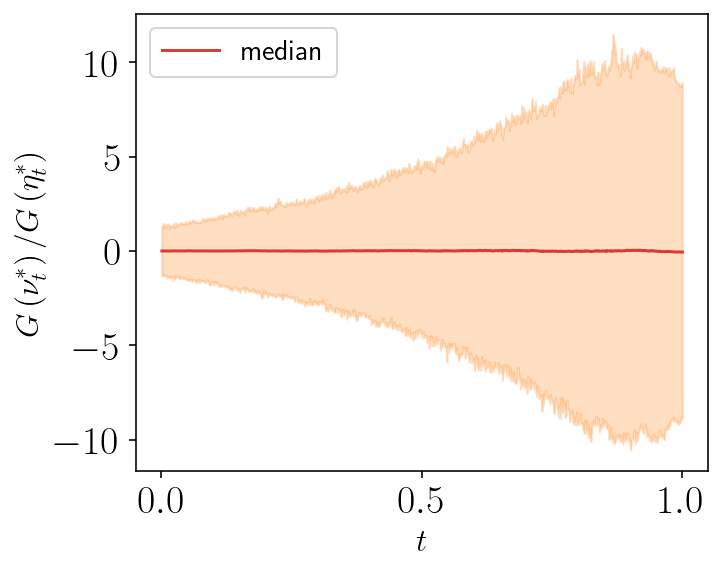

In [21]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

ax.plot(env.timesteps[1:], np.median(ratio_IB_base,axis=1),  'tab:red', alpha = 0.9, label = 'median')
ax.fill_between(env.timesteps[1:].reshape(-1,),qtl_IB_base[0],qtl_IB_base[-1],alpha=0.25, color='tab:orange')
ax.legend(loc = 'upper left')
ax.set_ylabel(r'$G\left(\nu^*_t\right) / G\left(\eta^*_t\right)$', fontsize = 16)
ax.set_xlabel(r'$t$', fontsize = 16)
resolution_value = 100
plt.tight_layout()

ax.set_xlabel(r'$t$', fontsize = font1)
ax.tick_params(axis='both', which='major', labelsize=font2)

#plt.ylim(-5,5)

plt.savefig('figures/externalisation_plot_filtering_I.pdf', format="pdf", dpi=resolution_value)
plt.show()

In [22]:
sim_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))
broker_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))

In [23]:
for param_name in param_list_name:
    
    for err_name, param_val in param_list_val[param_name].items():
        
        param = param_list_base.copy()
        param[param_name] = param_val

        params_env_stressed = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': param['kappa_alpha'], 'sigma_alpha': param['sigma_alpha'], 
                           'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

        env_stressed = utils_old.environment(**params_env_stressed)
        
        np.random.seed(seed_alpha)
        alpha_stressed = env_stressed.simulate_alpha(nsims = nsims)

        params_inf_stressed = {'env': env_stressed, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                          'sigma_B' : param['sigma_B'], 'mu_B' : 0., 'theta_B' : param['theta_B'], 'sigma_0' : 0, 'c_importance' : 1}

        inf_trader_stressed =  utils_old.informed(**params_inf_stressed)

        inf_trader_collections_stressed[param_name].append(inf_trader_stressed)

        params_broker_stressed = {'env': env_stressed, 'inf': inf_trader_stressed, 'uninf': uninf_trader,
                         'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                         'sigma_B': inf_trader_stressed.sigma_B, 'mu_B': inf_trader_stressed.mu_B, 'theta_B': inf_trader_stressed.theta_B, 
                         'sigma_0': 0, 'scale_ivp': scale_ivp}

        broker_stressed = utils_old.broker(**params_broker_stressed)

        broker_collections_stressed[param_name].append(broker_stressed)

        model = simulations_old.simulation(env_stressed, inf_trader_stressed, uninf_trader, broker_stressed, 
                                       W, alpha_stressed, nu_U, 
                                       strategy = strategy, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

        sim_collections_stressed[param_name].append(model)

In [24]:
param_label = {'kappa_alpha': r'$\kappa^\alpha$',
               'sigma_alpha': r'$\sigma^\alpha$',
               'theta_B': r'$\theta^B$',
               'sigma_B': r'$\sigma^B$'}

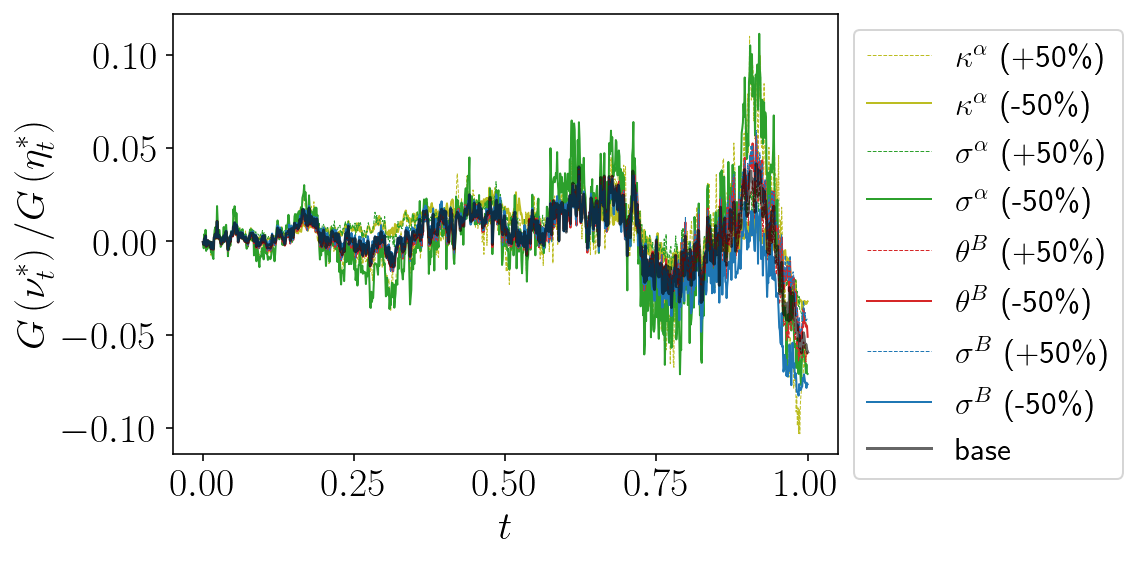

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

for ip, param_name in enumerate(param_list_name):
    
    for j, (err_name, param_val) in enumerate(param_list_val[param_name].items()):
        
        nu_B = sim_collections_stressed[param_name][j].nu_B
        nu_I = sim_collections_stressed[param_name][j].nu_I
        ratio_IB = auxF(nu_B[1:, :])/auxF(nu_I[1:, :])
        ratio_IB_median = np.median(ratio_IB,axis=1)
        
        if j==0:
            ax.plot(env.timesteps[1:], ratio_IB_median, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '--', linewidth = 0.5)
        else:
            ax.plot(env.timesteps[1:], ratio_IB_median, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '-', linewidth = 1)
        
ax.plot(env.timesteps[1:], ratio_IB_base_median, label='base', color='black', alpha=0.6)

ax.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize = font1)

ax.set_xlabel(r'$t$', fontsize = font2)
ax.tick_params(axis='both', which='major', labelsize=font2)
ax.set_ylabel(r'$G\left(\nu^*_t\right) / G\left(\eta^*_t\right)$', fontsize = font2)

plt.tight_layout()
plt.savefig('figures/externalisation_plot_filtering_quotient_I.pdf', format="pdf", dpi=resolution_value)

plt.show()

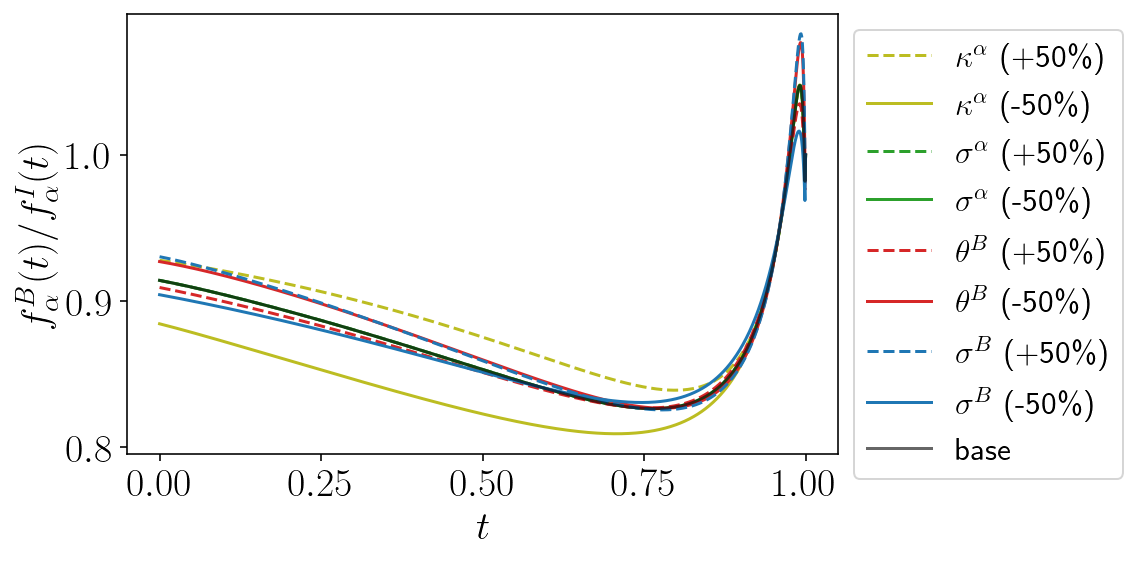

In [26]:
coef_alpha_B_base= broker.coef_speed_B[:, 0, 2]
z_base = inf_trader.z
coef_alpha_I_base = z_base[1] / 2 / inf_trader.k

ratio_coef_alpha_base = auxF(coef_alpha_I_base)/auxF(coef_alpha_B_base)

fig, ax = plt.subplots(1,1,figsize=(8,4))

for ip, param_name in enumerate(param_list_name):
    
    for j, (err_name, param_val) in enumerate(param_list_val[param_name].items()):
        
        coef_alpha_B = broker_collections_stressed[param_name][j].coef_speed_B[:, 0, 2]
        z = inf_trader_collections_stressed[param_name][j].z
        coef_alpha_I = z[1] / 2 / inf_trader_collections_stressed[param_name][j].k
        
        ratio_coef_alpha = auxF(coef_alpha_I)/auxF(coef_alpha_B)
        
        if j ==0:
            ax.plot(env.timesteps, 1./ratio_coef_alpha, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '--')
        else:
            ax.plot(env.timesteps, 1./ratio_coef_alpha, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '-')
        
ax.plot(env.timesteps, 1./ratio_coef_alpha_base, label='base', color='black', alpha=0.6)

ax.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize = font1)

ax.set_xlabel(r'$t$', fontsize = font2)
ax.tick_params(axis='both', which='major', labelsize=font2)
#ax.set_ylabel(r'$\frac{f_\alpha^I(t)}{f_\alpha^B(t)}$', fontsize = font1)
ax.set_ylabel(r'${f_\alpha^B(t)}/{f_\alpha^I(t)}$', fontsize = font2)

plt.tight_layout()
plt.savefig('figures/externalisation_plot_filtering_coefficient_I.pdf', format="pdf", dpi=resolution_value)

plt.show()

In [27]:
param_list_val[param_name]

{'+50\\%': 90.0, '-50\\%': 30.0}

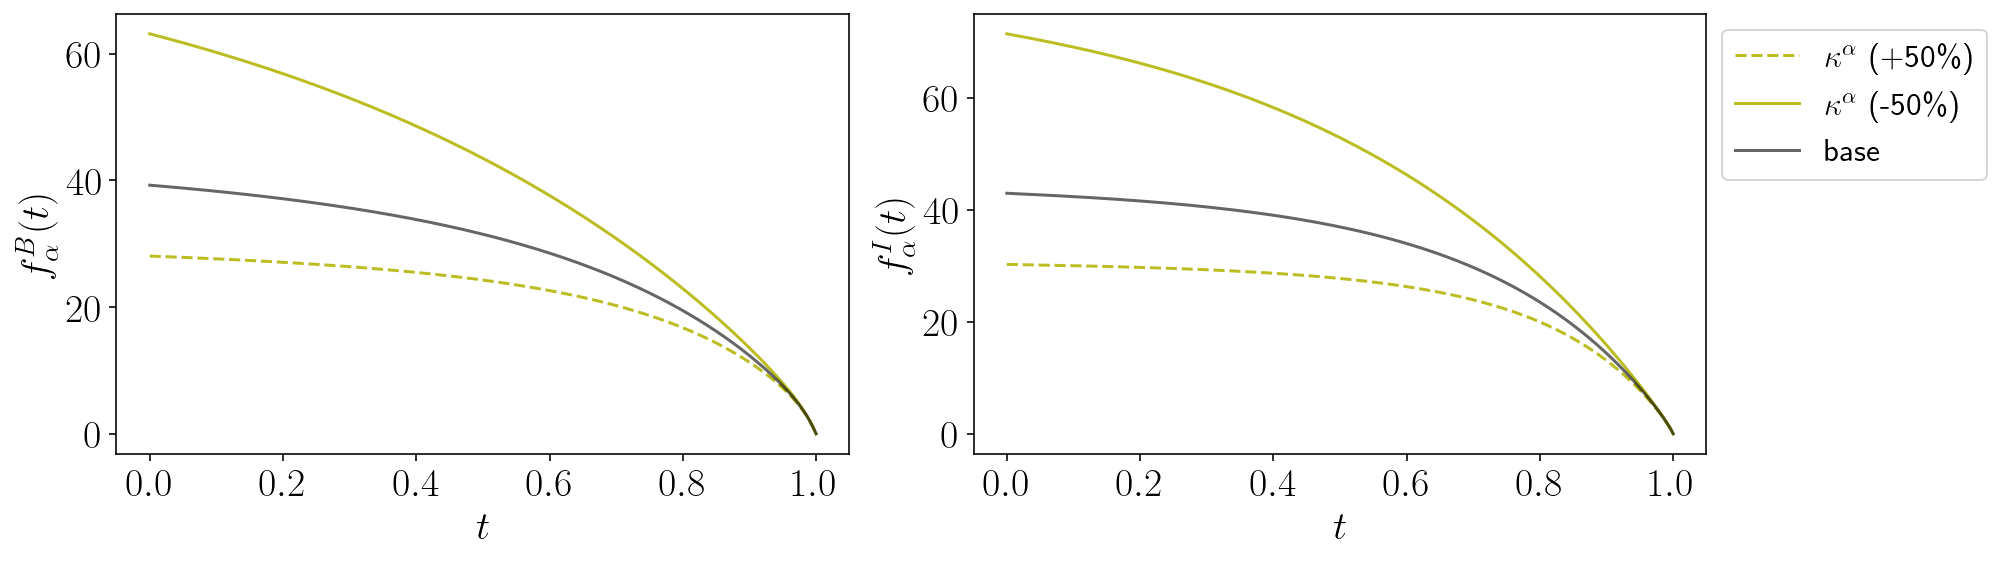

In [28]:
coef_alpha_B_base = broker.coef_speed_B[:, 0, 2]
z_base = inf_trader.z
coef_alpha_I_base = z_base[1] / 2 / inf_trader.k

fig, ax = plt.subplots(1,2,figsize=(14,4))

param_name = 'kappa_alpha'
ip = 0
    
for j, (err_name, param_val) in enumerate(param_list_val[param_name].items()):

    coef_alpha_B = broker_collections_stressed[param_name][j].coef_speed_B[:, 0, 2]
    z = inf_trader_collections_stressed[param_name][j].z
    coef_alpha_I = z[1] / 2 / inf_trader_collections_stressed[param_name][j].k

    if j == 0:
        ax[0].plot(env.timesteps, coef_alpha_B, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '--')
        ax[1].plot(env.timesteps, coef_alpha_I, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '--')
    else:
        ax[0].plot(env.timesteps, coef_alpha_B, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '-')
        ax[1].plot(env.timesteps, coef_alpha_I, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '-')

ax[0].plot(env.timesteps, coef_alpha_B_base, label='base', color='black', alpha=0.6)
ax[1].plot(env.timesteps, coef_alpha_I_base, label='base', color='black', alpha=0.6)

ax[1].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize = font1)

ax[0].set_xlabel(r'$t$', fontsize = font2)
ax[1].set_xlabel(r'$t$', fontsize = font2)
ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
#ax.set_ylabel(r'$\frac{f_\alpha^I(t)}{f_\alpha^B(t)}$', fontsize = font1)
ax[0].set_ylabel(r'${f_\alpha^B(t)}$', fontsize = font2)
ax[1].set_ylabel(r'${f_\alpha^I(t)}$', fontsize = font2)

plt.tight_layout()
plt.savefig('figures/externalisation_plot_filtering_alpha_coefficient_I.pdf', format="pdf", dpi=resolution_value)

plt.show()

# Our model: Naive filter

In [29]:
strategy = "naive filter"

In [30]:
model_base = simulations_old.simulation(env, inf_trader, uninf_trader, broker, 
                                   W, alpha, nu_U, 
                                   strategy = strategy, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

In [31]:
def auxF(x, tol=1e-10):
    return np.maximum(x,tol)*(x>=0) + np.minimum(x,-tol)*(x<0)

In [32]:
eps = 1e-1
#ratio_IB = (eps + np.abs(nu_I[1:]))/(eps + np.abs(nu_B[1:])) #np.exp(nu_I)/(np.exp(nu_B) + np.exp(nu_I) )
ratio_IB_base = auxF(model_base.nu_B[1:, :])/auxF(model_base.nu_I[1:, :]) #np.exp(nu_I)/(np.exp(nu_B) + np.exp(nu_I) )
ratio_IB_base_median = np.median(ratio_IB_base,axis=1)
#ratio_iI = (eps + np.abs(nu_I[1:]))/(eps + np.abs(nu_iI[1:]))#np.exp(nu_iI)/(np.exp(nu_iI) + np.exp(nu_I) )

qtl_IB_base = np.quantile(ratio_IB_base,[0.05,0.95], axis=1)
#qtl_iI = np.quantile(ratio_iI,[0.05,0.95], axis=1)

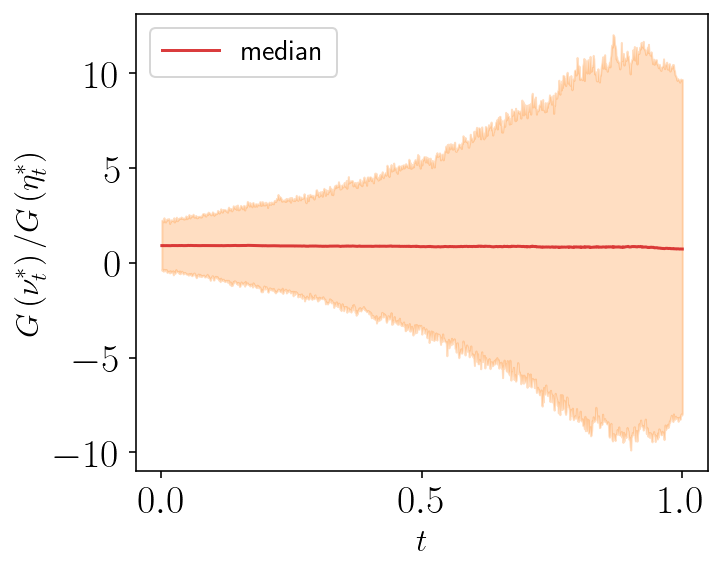

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

ax.plot(env.timesteps[1:], np.median(ratio_IB_base,axis=1),  'tab:red', alpha = 0.9, label = 'median')
ax.fill_between(env.timesteps[1:].reshape(-1,),qtl_IB_base[0],qtl_IB_base[-1],alpha=0.25, color='tab:orange')
ax.legend(loc = 'upper left')
ax.set_ylabel(r'$G\left(\nu^*_t\right) / G\left(\eta^*_t\right)$', fontsize = 16)
ax.set_xlabel(r'$t$', fontsize = 16)
resolution_value = 100
plt.tight_layout()

ax.set_xlabel(r'$t$', fontsize = font1)
ax.tick_params(axis='both', which='major', labelsize=font2)

#plt.ylim(-5,5)

plt.savefig('figures/externalisation_plot_filtering_II.pdf', format="pdf", dpi=resolution_value)
plt.show()

In [34]:
sim_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))
broker_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))

In [35]:
for param_name in param_list_name:
    
    for err_name, param_val in param_list_val[param_name].items():
        
        param = param_list_base.copy()
        param[param_name] = param_val

        params_env_stressed = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': param['kappa_alpha'], 'sigma_alpha': param['sigma_alpha'], 
                           'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

        env_stressed = utils_old.environment(**params_env_stressed)
        
        np.random.seed(seed_alpha)
        alpha_stressed = env_stressed.simulate_alpha(nsims = nsims)

        params_inf_stressed = {'env': env_stressed, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                          'sigma_B' : param['sigma_B'], 'mu_B' : 0., 'theta_B' : param['theta_B'], 'sigma_0' : 0, 'c_importance' : 1}

        inf_trader_stressed =  utils_old.informed(**params_inf_stressed)

        inf_trader_collections_stressed[param_name].append(inf_trader_stressed)

        params_broker_stressed = {'env': env_stressed, 'inf': inf_trader_stressed, 'uninf': uninf_trader,
                         'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                         'sigma_B': inf_trader_stressed.sigma_B, 'mu_B': inf_trader_stressed.mu_B, 'theta_B': inf_trader_stressed.theta_B, 
                         'sigma_0': 0, 'scale_ivp': scale_ivp}

        broker_stressed = utils_old.broker(**params_broker_stressed)

        broker_collections_stressed[param_name].append(broker_stressed)

        model = simulations_old.simulation(env_stressed, inf_trader_stressed, uninf_trader, broker_stressed, 
                                       W, alpha_stressed, nu_U, 
                                       strategy = strategy, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

        sim_collections_stressed[param_name].append(model)

In [36]:
param_label = {'kappa_alpha': r'$\kappa^\alpha$',
               'sigma_alpha': r'$\sigma^\alpha$',
               'theta_B': r'$\theta^B$',
               'sigma_B': r'$\sigma^B$'}

In [37]:
font1 = 16 #25
font2 = 20

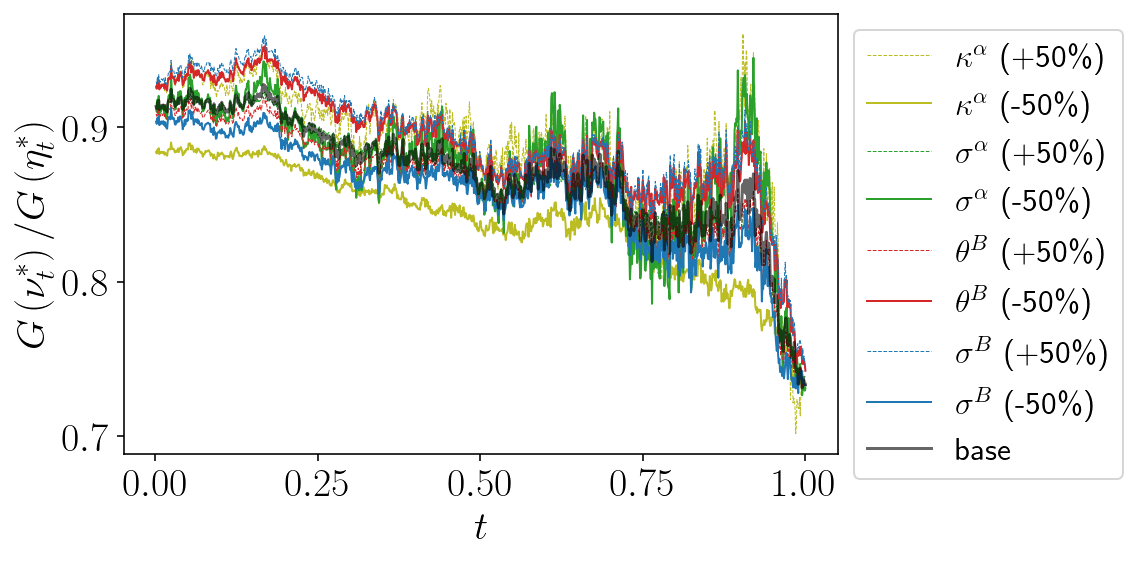

In [38]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

for ip, param_name in enumerate(param_list_name):
    
    for j, (err_name, param_val) in enumerate(param_list_val[param_name].items()):
        
        nu_B = sim_collections_stressed[param_name][j].nu_B
        nu_I = sim_collections_stressed[param_name][j].nu_I
        ratio_IB = auxF(nu_B[1:, :])/auxF(nu_I[1:, :])
        ratio_IB_median = np.median(ratio_IB,axis=1)
        
        if j==0:
            ax.plot(env.timesteps[1:], ratio_IB_median, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '--', linewidth = 0.5)
        else:
            ax.plot(env.timesteps[1:], ratio_IB_median, label=param_label[param_name] + f' ({err_name})', color = variable_colors[ip], linestyle = '-', linewidth = 1)
ax.plot(env.timesteps[1:], ratio_IB_base_median, label='base', color='black', alpha=0.6)


ax.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize = font1)

ax.set_xlabel(r'$t$', fontsize = font2)
ax.tick_params(axis='both', which='major', labelsize=font2)
ax.set_ylabel(r'$G\left(\nu^*_t\right) / G\left(\eta^*_t\right)$', fontsize = font2)

plt.tight_layout()
plt.savefig('figures/externalisation_plot_filtering_quotient_II.pdf', format="pdf", dpi=resolution_value)

plt.show()

In [39]:
param_list_val

{'kappa_alpha': {'+50\\%': 7.5, '-50\\%': 2.5},
 'sigma_alpha': {'+50\\%': 1.5, '-50\\%': 0.5},
 'theta_B': {'+50\\%': 15.0, '-50\\%': 5.0},
 'sigma_B': {'+50\\%': 90.0, '-50\\%': 30.0}}